# Pylops - Least squares migration (with amplitudes)


### Author: M.Ravasi

In this notebook I will show you how to perform least-squares migration with a Kirchhoff modelling operator.

The modelling is simply expressed by the following equation

$$ d(s, r, t) = w(t) * \int_V G(x,s, t) G(r,x, t) r(x,z) dx dz$$

where $r(x, z)$ is our model and it represents the reflectivity at every location in the subsurface, $G(r,x, t)$ and $G(x,s, t)$ are the Green's functions from source to subsurface to receiver and finally $w$ is the wavelet.

In a matrix for

$$ \mathbf{d} = \mathbf{W} \mathbf{G} \mathbf{r}$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

## 2D layered in homogenous velocity

Lets' create a model and geometry

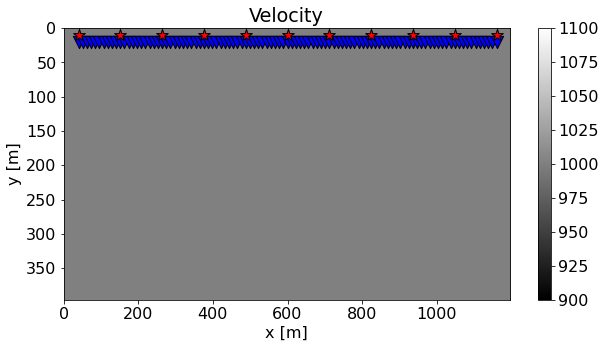

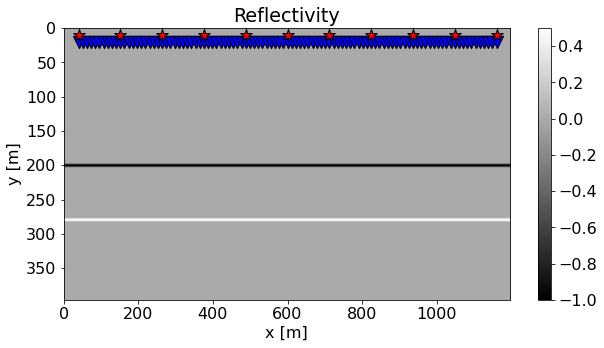

In [2]:
# Velocity Model
nx, nz = 300, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
#refl[:, 20] = 1
refl[:, 50] = -1
refl[:, 70] = 0.5

# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 11
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

Compute traveltimes for homogenous medium

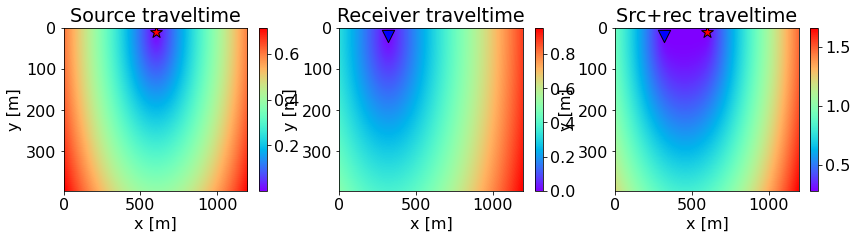

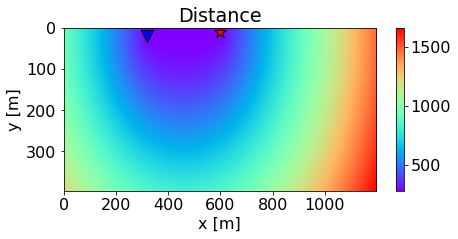

In [3]:
trav_srcs, trav_recs, dist_srcs, dist_recs, trav_srcs_grad, trav_recs_grad = \
    Kirchhoff._traveltime_table(z, x, sources, recs, v0, mode='analytic')

trav = trav_srcs.reshape(nx * nz, ns, 1) + trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)
dist = dist_srcs.reshape(nx * nz, ns, 1) + dist_recs.reshape(nx * nz, 1, nr)
dist = dist.reshape(nx * nz, ns * nr)


fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
im = ax.imshow(dist[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
ax.scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Distance')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

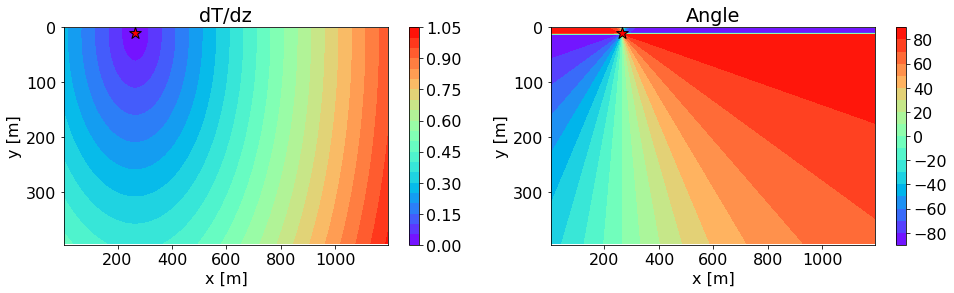

In [4]:
# Compute angles
theta = np.arctan(trav_srcs_grad[0][..., ns//4]/trav_srcs_grad[1][..., ns//4]).reshape((nx, nz)).T

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
im = axs[0].contourf(trav_srcs[..., ns//4].reshape((nx, nz)).T, cmap='rainbow', 
                     levels=20, origin='upper', extent=(x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//4], sources[1, ns//4], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('dT/dz')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].contourf(np.rad2deg(theta), 
                     levels=20, cmap='rainbow', 
                     origin='upper', extent=(x[0], x[-1], z[-1], z[0]))
axs[1].scatter(sources[0, ns//4], sources[1, ns//4], marker='*', s=150, c='r', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Angle')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1]);

Let's do the same using an eikonal solver

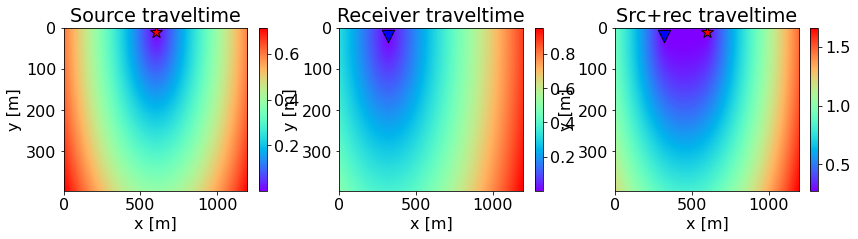

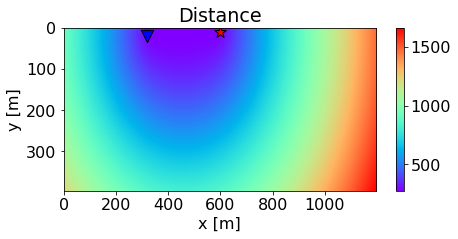

In [5]:
trav_srcs_eik, trav_recs_eik, dist_srcs_eik, dist_recs_eik, _, _ = \
    Kirchhoff._traveltime_table(z, x, sources, recs, vel, mode='eikonal')

trav_eik = trav_srcs_eik.reshape(nx * nz, ns, 1) + trav_recs_eik.reshape(nx * nz, 1, nr)
trav_eik = trav_eik.reshape(nx * nz, ns * nr)
dist_eik = dist_srcs_eik.reshape(nx * nz, ns, 1) + dist_recs_eik.reshape(nx * nz, 1, nr)
dist_eik = dist_eik.reshape(nx * nz, ns * nr)


fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs_eik[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs_eik[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav_eik[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2])

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
im = ax.imshow(dist_eik[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
ax.scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Distance')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

Finally we model the data and invert it

In [6]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

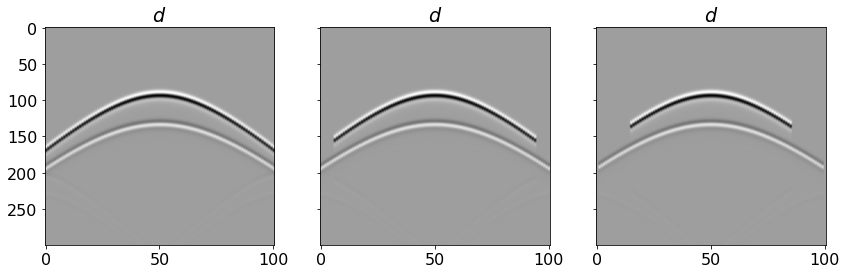

In [7]:
# Checking spatial aperture
kirch1 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True, 
                   mode='analytic', engine='numba', aperture=None)
d1 = kirch1 * refl.ravel()
d1 = d1.reshape(ns, nr, nt)

kirch2 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True,
                   mode='analytic', engine='numba', aperture=2.5)
d2 = kirch2 * refl.ravel()
d2 = d2.reshape(ns, nr, nt)

kirch3 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True,
                   mode='analytic', engine='numba', aperture=2)
d3 = kirch3 * refl.ravel()
d3 = d3.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 4))
axs[0].imshow(d1[ns//2, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d2[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d$')
axs[1].axis('tight')
axs[2].imshow(d3[ns//2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d$')
axs[2].axis('tight');

Dot test passed, v^H(Opu)=0.01422716889606223 - u^H(Op^Hv)=0.014227168896062183


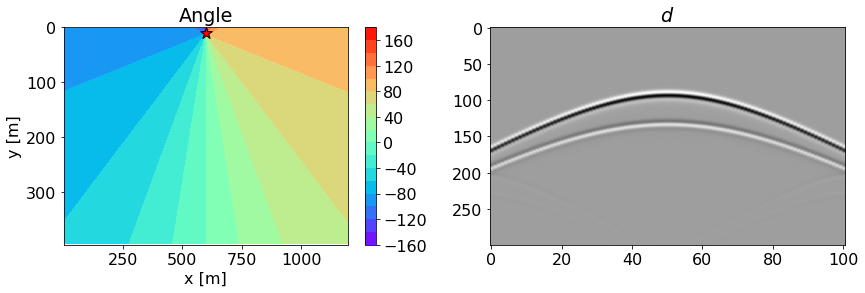

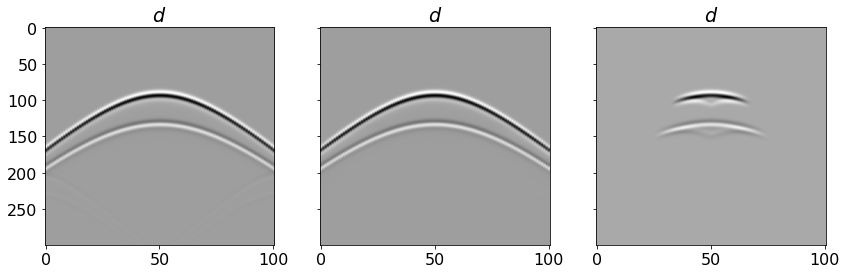

In [8]:
# Checking angle aperture
kirch1 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True, 
                   mode='analytic', engine='numba', aperture=None)
d1 = kirch1 * refl.ravel()
d1 = d1.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
im = axs[0].contourf(np.rad2deg(kirch1.angle_srcs[:, ns//2].reshape(nx, nz).T), 
                     levels=20, cmap='rainbow', origin='upper', extent=(x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Angle')
axs[0].set_ylim(z[-1], z[0])
axs[1].imshow(d1[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[0])

kirch2 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True,
                   mode='analytic', engine='numba', aperture=None, angleaperture=70)
d2 = kirch2 * refl.ravel()
d2 = d2.reshape(ns, nr, nt)
dottest(kirch2, verb=True)

kirch3 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True,
                   mode='analytic', engine='numba', angleaperture=30)
d3 = kirch3 * refl.ravel()
d3 = d3.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 4))
axs[0].imshow(d1[ns//2, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d2[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d$')
axs[1].axis('tight')
axs[2].imshow(d3[ns//2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d$')
axs[2].axis('tight');

Finally we use space and angle limitations together

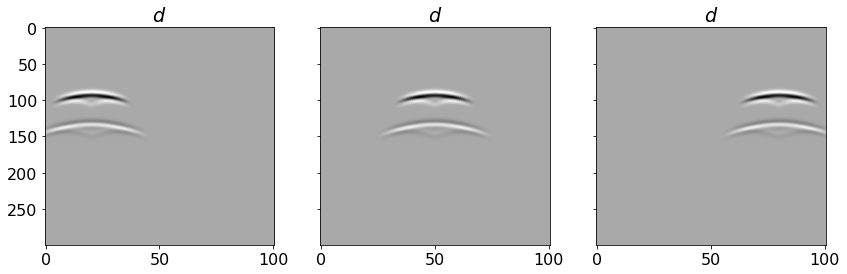

In [9]:
# Checking angle aperture
kirch1 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True, 
                   mode='analytic', engine='numba', aperture=2, angleaperture=30)
d1 = kirch1 * refl.ravel()
d1 = d1.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 4))
axs[0].imshow(d1[ns//4, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(d1[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d$')
axs[1].axis('tight')
axs[2].imshow(d1[3*ns//4, :, :300].T, cmap='gray')
axs[2].set_title(r'$d$')
axs[2].axis('tight');

And with or without the Snell's law activated

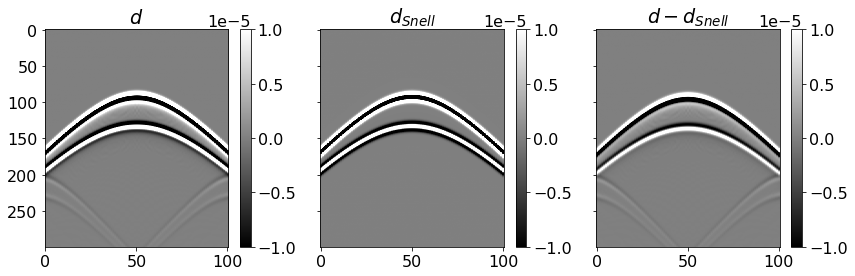

In [10]:
# Checking Snell's law
kirch1 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True, 
                   mode='analytic', engine='numba', snell=None)
d1 = kirch1 * refl.ravel()
d1 = d1.reshape(ns, nr, nt)

kirch2 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True, 
                   mode='analytic', engine='numba', snell=20.)
d2 = kirch2 * refl.ravel()
d2 = d2.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 4))
im = axs[0].imshow(d1[ns//2, :, :300].T, cmap='gray', vmin=-1e-5, vmax=1e-5)
axs[0].set_title(r'$d$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(d2[ns//2, :, :300].T, cmap='gray', vmin=-1e-5, vmax=1e-5)
axs[1].set_title(r'$d_{Snell}$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(d1[ns//2, :, :300].T-d2[ns//2, :, :300].T, cmap='gray', vmin=-1e-5, vmax=1e-5)
axs[2].set_title(r'$d-d_{Snell}$')
axs[2].axis('tight')
plt.colorbar(im, ax=axs[2]);

And now inversion

In [11]:
lsm = LSM(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', engine='numba',
          dynamic=True, angleaperture=70, snell=5.)
dottest(lsm.Demop, verb=True)

d = lsm.Demop * refl.ravel()
d = d.reshape(ns, nr, nt)

madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=100, show=True))
minv = minv.reshape(nx, nz)

minv_sparse = lsm.solve(d.ravel(), solver=fista, **dict(eps=1e-10, tol=0, niter=100, show=True))
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = lsm.Demop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = lsm.Demop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = lsm.Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

Dot test passed, v^H(Opu)=0.0005705003217580181 - u^H(Op^Hv)=0.0005705003217580427
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 723261 rows and 30000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.208e-03  1.208e-03    1.0e+00  9.9e-02
     1  0.00000e+00   5.476e-04  5.476e-04    4.5e-01  6.9e-01   1.3e-04  1.0e+00
     2  0.00000e+00   3.684e-04  3.684e-04    3.0e-01  4.2e-01   1.9e-04  2.1e+00
     3  0.00000e+00   2.682e-04  2.682e-04    2.2e-01  3.0e-01   2.3e-04  3.5e+00
     4  0.00000e+00   2.065e-04  2.065e-04    1.7e-01  2.5e-01   2.7e-04  5.1e+00
     5  0.00000e+00   1.703e-04  1.703e-04    1.4e-01  1.8e-01   3.0e-04  6.7e+00
     6  0.00000e+00   1.445e-04  1.445e-04    1.2e-01  1.6e-01   3.3e-04  8.5e+00
     7  0.00000e+00   1.217e-0

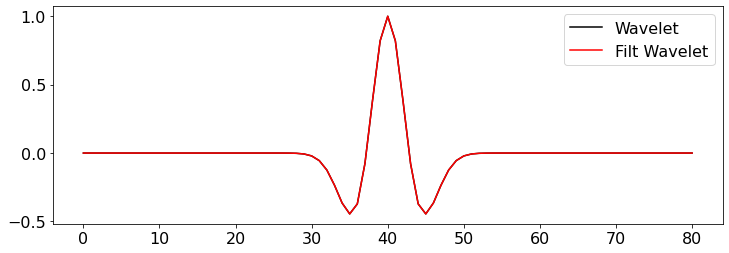

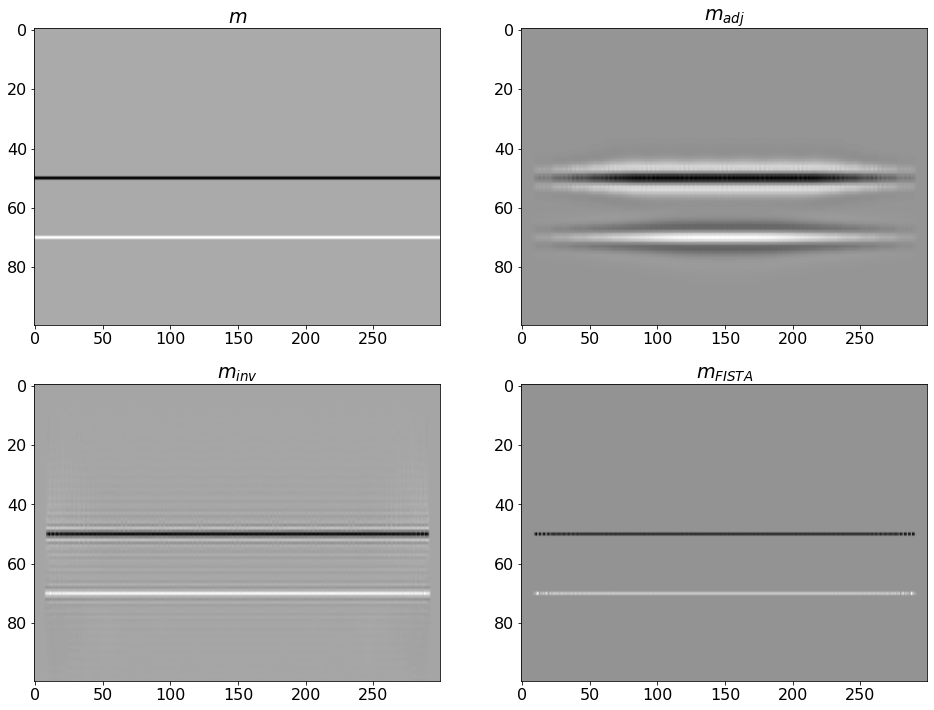

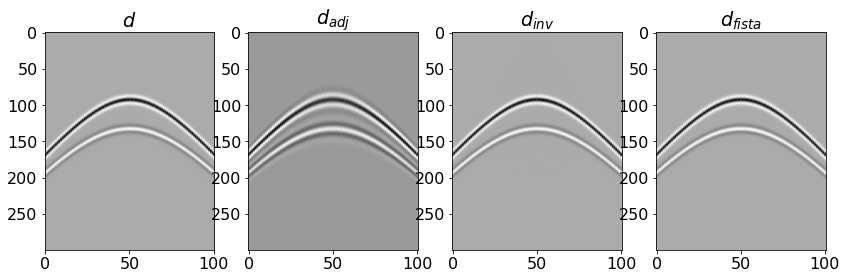

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(wav / wav.max(), 'k', label='Wavelet')
plt.plot(lsm.Demop.wav / lsm.Demop.wav.max(), 'r', label='Filt Wavelet')
plt.legend()

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs[0][0].imshow(refl.T, cmap='gray')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$')
axs[1][1].imshow(minv_sparse.T, cmap='gray')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$')

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight')
axs[3].imshow(dinv_sparse[ns//2, :, :300].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight');

## Marmousi model

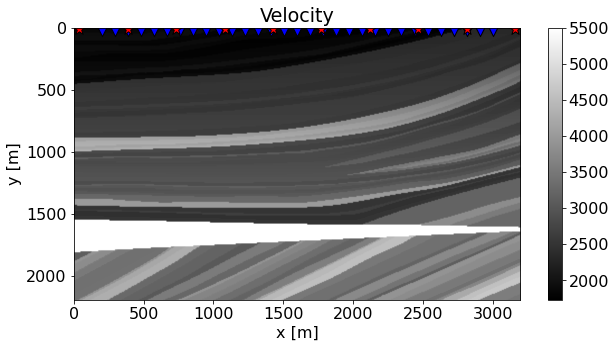

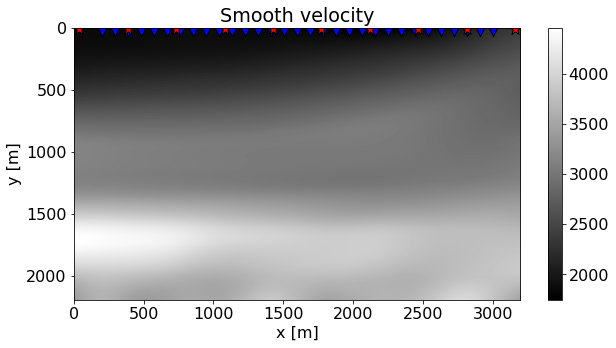

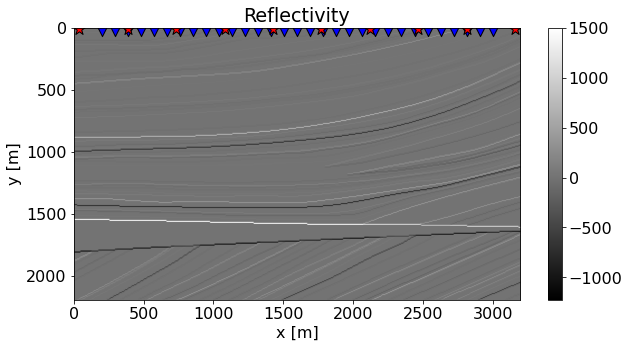

In [13]:
#Velocity
inputfile='../../pylops/testdata/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
nx, nz = len(x), len(z)

# Reflectivity
refl = np.diff(vel_true, axis=1)
refl = np.hstack([refl, np.zeros((nx, 1))])

# Smooth velocity
nsmooth=100
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel, axis=1)

# Receivers
nr = 31
rx = np.linspace(dx*50, (nx-50)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 10
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0]);

Compute traveltimes with eikonal

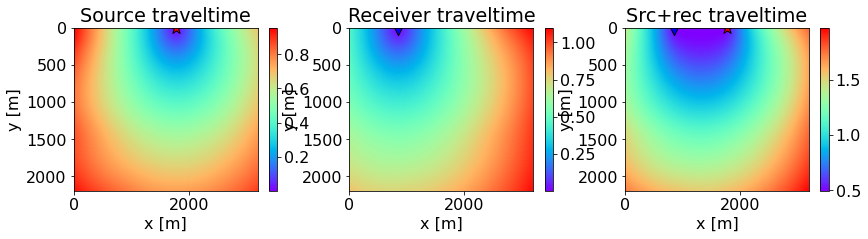

In [14]:
trav_srcs, trav_recs, dist_srcs, dist_recs, trav_srcs_grad, trav_recs_grad = \
    Kirchhoff._traveltime_table(z, x, sources, recs, vel, mode='eikonal')

trav = trav_srcs.reshape(nx * nz, ns, 1) + trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

Create data and invert model

In [15]:
nt = 751
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=15)

LSMopfull = Kirchhoff(z, x, t, sources, recs, vel, wav, wavc, dynamic=False, 
                      mode='eikonal', engine='numba')
LSMop = Kirchhoff(z, x, t, sources, recs, vel, wav, wavc, dynamic=True, 
                  mode='eikonal', engine='numba', angleaperture=91)
LSMopap = Kirchhoff(z, x, t, sources, recs, vel, wav, wavc, dynamic=True, 
                    mode='eikonal', engine='numba', angleaperture=30)

# data
dtrav = LSMopfull * refl.ravel()
dtrav = dtrav.reshape(ns, nr, nt)

d = LSMop * refl.ravel()
d = d.reshape(ns, nr, nt)

dap = LSMopap * refl.ravel()
dap = dap.reshape(ns, nr, nt)

# migration
madj = LSMopfull.H * dtrav.ravel()
madj = madj.reshape(nx, nz)

madj1 = LSMop.H * dtrav.ravel()
madj1 = madj1.reshape(nx, nz)

madj2 = LSMopap.H * dtrav.ravel()
madj2 = madj2.reshape(nx, nz)

# demigration
dadj = LSMopfull * madj1.ravel()
dadj = dadj.reshape(ns, nr, nt)

dadj1 = LSMop * madj1.ravel()
dadj1 = dadj1.reshape(ns, nr, nt)

dadj2 = LSMop * madj1.ravel()
dadj2 = dadj2.reshape(ns, nr, nt)

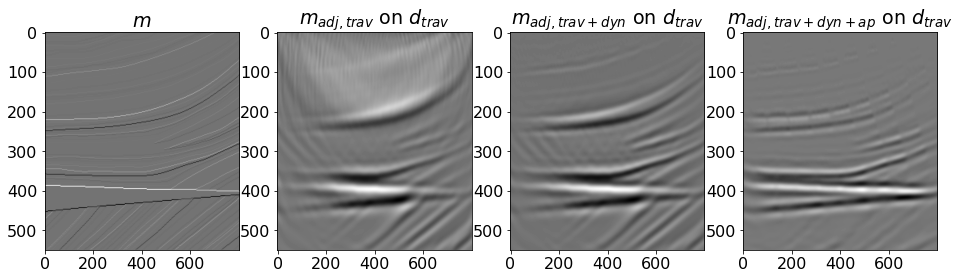

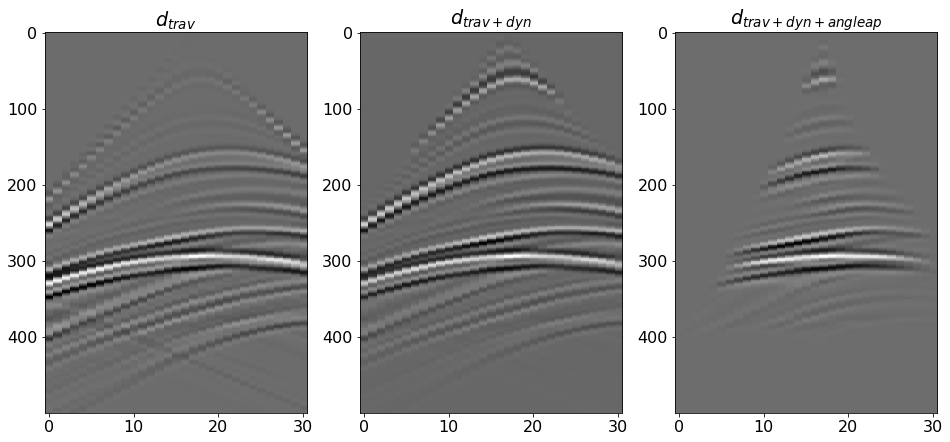

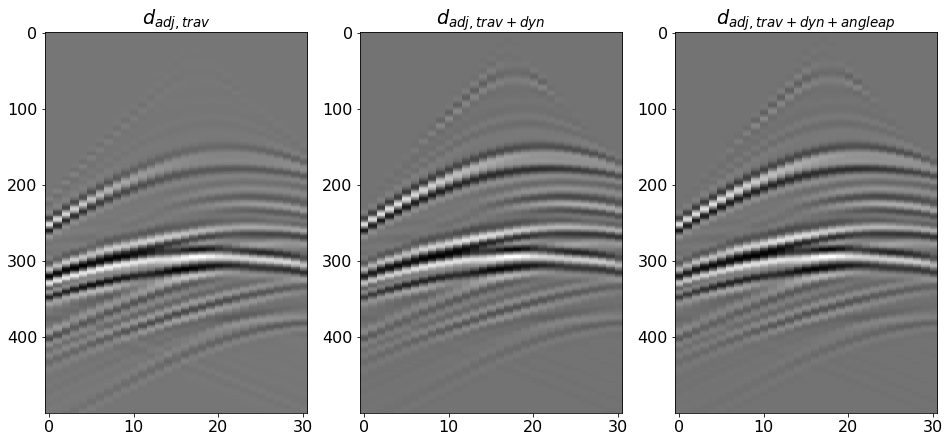

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(refl.T, cmap='gray')
axs[0].axis('tight')
axs[0].set_title(r'$m$')
axs[1].imshow(madj.T, cmap='gray')
axs[1].set_title(r'$m_{adj,trav}$ on $d_{trav}$')
axs[1].axis('tight')
axs[2].imshow(madj1.T, cmap='gray')
axs[2].set_title(r'$m_{adj,trav+dyn}$ on $d_{trav}$')
axs[2].axis('tight')
axs[3].imshow(madj2.T, cmap='gray')
axs[3].set_title(r'$m_{adj,trav+dyn+ap}$ on $d_{trav}$')
axs[3].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(16, 7))
axs[0].imshow(dtrav[ns//2, :, :500].T, cmap='gray', interpolation='none')
axs[0].set_title(r'$d_{trav}$')
axs[0].axis('tight')
axs[1].imshow(d[ns//2, :, :500].T, cmap='gray', interpolation='none')
axs[1].set_title(r'$d_{trav+dyn}$')
axs[1].axis('tight')
axs[2].imshow(dap[ns//2, :, :500].T, cmap='gray', interpolation='none')
axs[2].set_title(r'$d_{trav+dyn+angleap}$')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(16, 7))
axs[0].imshow(dadj[ns//2, :, :500].T, cmap='gray', interpolation='none')
axs[0].set_title(r'$d_{adj,trav}$')
axs[0].axis('tight')
axs[1].imshow(dadj1[ns//2, :, :500].T, cmap='gray', interpolation='none')
axs[1].set_title(r'$d_{adj,trav+dyn}$')
axs[1].axis('tight')
axs[2].imshow(dadj2[ns//2, :, :500].T, cmap='gray', interpolation='none')
axs[2].set_title(r'$d_{adj,trav+dyn+angleap}$')
axs[2].axis('tight');

In [17]:
lsm = LSM(z, x, t, sources, recs, vel, wav, wavc, mode='eikonal', engine='numba',
          dynamic=True, angleaperture=70)
dottest(lsm.Demop, verb=True)

d = lsm.Demop * refl.ravel()
d = d.reshape(ns, nr, nt)

madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=100, show=True))
minv = minv.reshape(nx, nz)

minv_sparse = lsm.solve(d.ravel(), solver=fista, **dict(eps=1e-8, tol=0, niter=100, show=True))
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = lsm.Demop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = lsm.Demop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = lsm.Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

Dot test passed, v^H(Opu)=-0.00021008723603481547 - u^H(Op^Hv)=-0.00021008723603483824
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 232810 rows and 440000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.036e+00  3.036e+00    1.0e+00  3.1e-05
     1  0.00000e+00   1.374e+00  1.374e+00    4.5e-01  7.1e-01   1.1e-04  1.0e+00
     2  0.00000e+00   9.059e-01  9.059e-01    3.0e-01  4.6e-01   1.5e-04  2.1e+00
     3  0.00000e+00   6.693e-01  6.693e-01    2.2e-01  3.2e-01   1.9e-04  3.5e+00
     4  0.00000e+00   5.130e-01  5.130e-01    1.7e-01  2.5e-01   2.2e-04  5.1e+00
     5  0.00000e+00   4.219e-01  4.219e-01    1.4e-01  2.0e-01   2.5e-04  6.7e+00
     6  0.00000e+00   3.508e-01  3.508e-01    1.2e-01  1.7e-01   2.8e-04  8.6e+00
     7  0.00000e+00   2.9

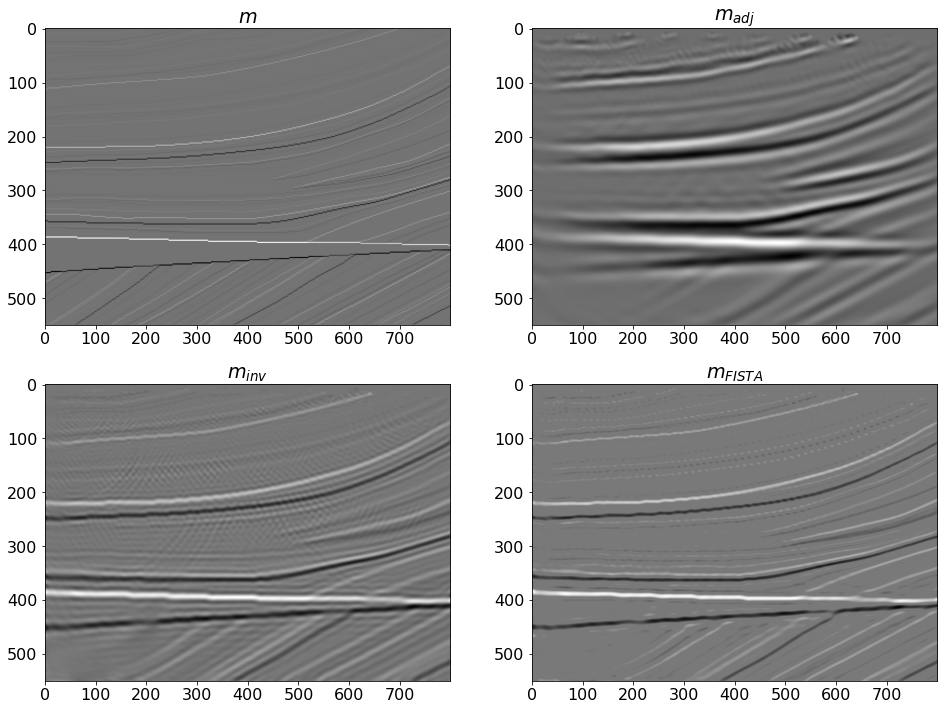

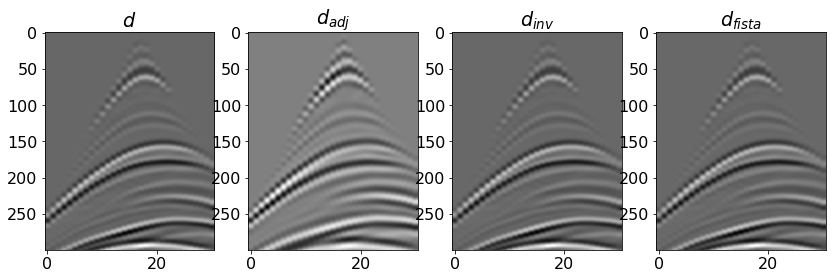

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs[0][0].imshow(refl.T, cmap='gray')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$')
axs[1][1].imshow(minv_sparse.T, cmap='gray')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$')

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight')
axs[3].imshow(dinv_sparse[ns//2, :, :300].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight');